In [44]:
import pandas as pd
import numpy as np
import torch

# Load and normalize data
Train_data = pd.read_csv('/Users/abhinavchhabra/Downloads/mnist_train.csv')
Test_data = pd.read_csv('/Users/abhinavchhabra/Downloads/mnist_test.csv')

X_train = Train_data.iloc[:, 1:] / 255.0
y_train = Train_data.iloc[:, 0]
y_train = torch.tensor(y_train)
X_test = Test_data.iloc[:, 1:] / 255.0
y_test = Test_data.iloc[:, 0]

T = 10  # number of timesteps
spike_trains = []

for i in range(len(X_train)):
    image = torch.tensor(X_train.iloc[i].values, dtype=torch.float32)  # shape: (784,)
    image = image.unsqueeze(0).repeat(T, 1)  # shape: (T, 784)

    noise = torch.rand(T, 784)  # uniform [0, 1)
    spike_train = (noise < image).to(torch.uint8)  # shape: (T, 784)

    spike_trains.append(spike_train)



Plotting the spike trains:

In [53]:
print(spike_trains[0].shape)

torch.Size([10, 784])


Text(0.5, 0, 'Digit: 0')

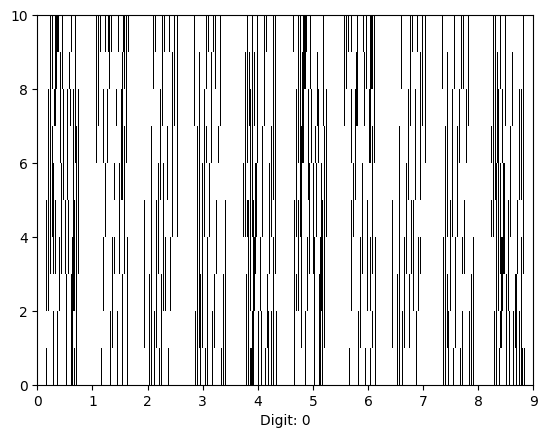

In [78]:
from nengo_extras.plot_spikes import plot_spikes
import matplotlib.pyplot as plt
plot_spikes(np.arange(0, T),spikes=spike_trains[1].reshape(28*28,T))
plt.xlabel(f'Digit: {y_train[1]}')

In [68]:

import torch.nn.functional as F
import torch
class LIFLayer():
    def __init__(self, input_size, output_size,hidden_size, threshold=1.0, decay=0.9,learning_rate = 0.1):
        self.first_layer = torch.randn(784, 128, requires_grad=False) * 0.1
        self.second_layer = torch.randn(128,128,requires_grad=False) * 0.1
        self.third_layer = torch.randn(128,10,requires_grad=False)*0.1
        self.threshold = threshold
        self.decay = decay
        self.reset_potential = 0.0
        self.T = 10
        self.spike_1 = []
        self.spike_2 = []
        self.spike_3 = []
        self.potentials_1 = []
        self.potentials_2 = []
        self.potentials_3 = []
        self.lr = learning_rate
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
    def forward(self, input_spike_train):
        # input_spike_train: shape (T, batch_size, input_size)
        T, B, _ = input_spike_train.shape
        output_1 = []
        mem = torch.zeros(B, self.hidden_size)
        potentials_1 = []
        for t in range(T):
            input_t = input_spike_train[t]  # shape: (B, input_size)
            current = input_t @ self.first_layer     # synaptic input
            mem = self.decay * mem + current

            spike = (mem >= self.threshold).float()
            mem[spike.bool()] = self.reset_potential
            potentials_1.append(mem)
            output_1.append(spike)
        self.spike_1 = torch.stack(output_1).clone()
        self.potentials_1 = torch.stack(potentials_1).clone()
        T,B,_ = self.spike_1.shape
        output_2 = []
        potentials_2 = []
        mem = torch.zeros(B, self.hidden_size)
        for t in range(T):
            input_t = self.spike_1[t]  # shape: (B, input_size)
            current = input_t @ self.second_layer     # synaptic input
            mem = self.decay * mem + current

            spike = (mem >= self.threshold).float()
            mem[spike.bool()] = self.reset_potential
            potentials_2.append(mem)
            output_2.append(spike)
        self.spike_2 = torch.stack(output_2).clone()
        self.potentials_2 = torch.stack(potentials_2).clone()

        T,B,_ = self.spike_2.shape
        output_3 = []
        potentials_3 = []
        mem = torch.zeros(B, self.output_size)
        for t in range(T):
            input_t = self.spike_2[t]  # shape: (B, input_size)
            current = input_t @ self.third_layer     # synaptic input
            mem = self.decay * mem + current

            spike = (mem >= self.threshold).float()
            mem[spike.bool()] = self.reset_potential
            potentials_3.append(mem)
            output_3.append(spike)
        self.spike_3 = torch.stack(output_3).clone()
        self.potentials_3 = torch.stack(potentials_3).clone()
        return self.spike_3

    def surrogate_derivative(self,x):
        return 1.0 / (1.0 + 100 * torch.abs(x - self.threshold))**2
    def backward(self,x,target):
        spike_output_sum = self.spike_3.sum(0)
        loss = F.mse_loss(spike_output_sum, target)
        grad_W3 = torch.zeros_like(self.third_layer)
        grad_W2 = torch.zeros_like(self.second_layer)
        grad_W1 = torch.zeros_like(self.first_layer)
        grad_output = 2 * (spike_output_sum - target) / 1
        for t in range(self.T):
            v3 = self.potentials_3[t]
            s2 = self.spike_2[t]
            surrogate_grad3 = self.surrogate_derivative(v3)

            delta3 = grad_output * surrogate_grad3  # (B, out)
            grad_W3 += s2.T @ delta3

            v2 = self.potentials_2[t]
            x2 = self.spike_1[t]
            surrogate_grad2 = self.surrogate_derivative(v2)

            delta2 = (delta3 @ self.third_layer.T) * surrogate_grad2  # (B, hidden)
            grad_W2 += x2.T @ delta2

            v1 = self.potentials_1[t]
            x1 = x[t]
            surrogate_grad1 = self.surrogate_derivative(v1)

            delta1 = (delta2 @ self.second_layer.T) * surrogate_grad1
            grad_W1 += x1.T @ delta1
        self.first_layer -= self.lr * grad_W1
        self.second_layer -= self.lr * grad_W2
        self.third_layer -= self.lr *grad_W3

        return loss.item()




        

In [70]:
print(spike_trains[0].shape)

torch.Size([10, 784])


In [ ]:
model = LIFLayer(784, 10, 128)
losses = []
for epoch in range(10):
    for i in range(len(spike_trains)):
        x = spike_trains[i].float().unsqueeze(1)  # shape: (T, 1, 784)
        y = F.one_hot(y_train[i], num_classes=10).float().unsqueeze(0)  # shape: (1, 10)
        output = model.forward(x)
        loss = model.backward(x,y)
    losses.append(loss)


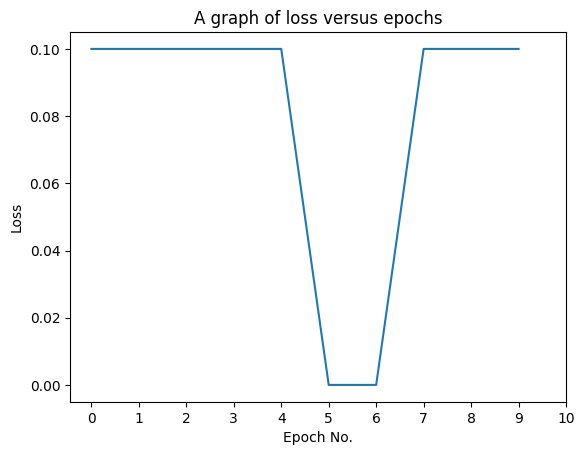

In [85]:
plt.plot(losses)
plt.xticks(np.arange(0, T+1, 1))
plt.xlabel("Epoch No.")
plt.ylabel("Loss")
plt.title("A graph of loss versus epochs")
plt.show()

In [80]:
T = 10  # number of timesteps
spike_tests = []
y_test = torch.tensor(y_test)
for i in range(len(X_test)):
    image = torch.tensor(X_test.iloc[i].values, dtype=torch.float32)  # shape: (784,)
    image = image.unsqueeze(0).repeat(T, 1)  # shape: (T, 784)

    noise = torch.rand(T, 784)  # uniform [0, 1)
    spike_test = (noise < image).to(torch.uint8)  # shape: (T, 784)

    spike_tests.append(spike_test)

/var/folders/dw/lq41h4dj3kg7w54q4lt5c37m0000gn/T/ipykernel_72043/2121057445.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


In [81]:
i = 0
for i in range(len(spike_tests)):
    x = spike_tests[i].float().unsqueeze(1)  # shape: (T, 1, 784)
    output = model.forward(x)
    output = torch.argmax(output)
    if(output+1 == y_test[i]):
        i+= 1
print(f"Accuracy = {(i/len(spike_tests))*100}")

Accuracy = 99.99
